In [1]:
import afqinsight as afq

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, MaxPooling1D, Dropout
from keras.regularizers import l1_l2, l2
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
import kerastuner as kt

In [3]:
pwd

'/Users/ceciliabarnes/Documents/DIRECT/afq-cnn/notebooks'

In [4]:
X, y, groups, feature_names, group_names, subjects, classes = afq.datasets.load_afq_data(
    workdir="../data/raw/cam-can",
    dwi_metrics=["dki_md", "dki_fa"],
    target_cols=["age"],
    index_col="Observations",
    fn_nodes="combined_tract_profiles.csv",
    fn_subjects="participant_data.tsv",
)

In [5]:
X.shape, y.shape

((641, 3600), (641,))

In [6]:
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
np.count_nonzero(np.isnan(y_test))

0

In [9]:
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)
#y_imp = SimpleImputer(strategy='median')
#y_imp.fit(y_train)
#y_train = imp.transform(y_train)
#y_test = imp.transform(y_test)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((480, 3600), (480,), (160, 3600), (160,))

In [11]:
X_train.shape[0]

480

In [12]:
X_train_reshaped = np.swapaxes(X_train.reshape((480, 36, 100)), 1, 2)
X_test_reshaped = np.swapaxes(X_test.reshape((160, 36, 100)), 1, 2)

In [13]:
X_train.shape, X_test.shape

((480, 3600), (160, 3600))

In [23]:
def cam_can_model_builder(hp):

    # input: 3+D tensor with shape: batch_shape + (steps, input_dim)
    # output: 3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.
    model = Sequential()
    
    filters1 = hp.Int('filters1', min_value=32, max_value=512, step=32)
    model.add(Dense(filters1, activation='relu', 
                    input_shape=X_train_reshaped.shape[1:]))
    
    filters2 = hp.Int('filters2', min_value=32, max_value=512, step=32)
    kernel1 = hp.Int('kernel1', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters2, kernel_size=kernel1, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters3 = hp.Int('filters3', min_value=32, max_value=512, step=32)
    kernel2 = hp.Int('kernel2', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters3, kernel_size=kernel2, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters4 = hp.Int('filters4', min_value=32, max_value=512, step=32)
    kernel3 = hp.Int('kernel3', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters4, kernel_size=kernel3, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters5 = hp.Int('filters5', min_value=32, max_value=512, step=32)
    kernel4 = hp.Int('kernel4', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters5, kernel_size=kernel4, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    
    filters6 = hp.Int('filters6', min_value=32, max_value=512, step=32)
    kernel5 = hp.Int('kernel5', min_value=1, max_value=4, step=1)
    model.add(Conv1D(filters6, kernel_size=kernel5, activation='relu'))
    
    model.add(MaxPool1D(pool_size=2,padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    filters7 = hp.Int('filters7', min_value=32, max_value=512, step=32)
    model.add(Dense(filters7, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
    return model

In [24]:
cam_can_tuner = kt.Hyperband(cam_can_model_builder,
                             objective='mean_squared_error',
                             max_epochs=5,
                             factor=3,
                             overwrite=True)

In [25]:
#callback = EarlyStopping(monitor='loss', patience=10)
cam_can_tuner.search(X_train_reshaped, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps=cam_can_tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 10 Complete [00h 00m 07s]
mean_squared_error: 395.4204406738281

Best mean_squared_error So Far: 393.8582458496094
Total elapsed time: 00h 01m 00s
INFO:tensorflow:Oracle triggered exit


In [27]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = cam_can_tuner.hypermodel.build(best_hps)

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [44]:
#history = model.fit(X_train_reshaped, y_train, epochs=50, validation_split=0.2)

#mse_per_epoch = history.history['mean_squared_error']
#best_epoch = mse_per_epoch.index(min(mse_per_epoch)) + 1
#print('Best epoch: %d' % (best_epoch,))
import os.path as op
weights_path = op.join("train", 'weights.hdf5')
model_checkpoint_callback = ModelCheckpoint(filepath=weights_path,
                                            monitor='val_loss',
                                            mode='auto',
                                            save_best_only=True,
                                            save_weights_only=True,
                                            verbose=True)

# Fitting model using model checkpoint callback to find best model which is saved to 'weights'
model.fit(X_train_reshaped, y_train, epochs=50, callbacks=[model_checkpoint_callback], validation_split=0.2)        

Epoch 1/50
12/12 [==============================] - 1s 82ms/step - loss: 21.2535 - mean_squared_error: 21.2535 - val_loss: 117.3266 - val_mean_squared_error: 117.3266

Epoch 00001: val_loss improved from inf to 117.32661, saving model to train/weights.hdf5
Epoch 2/50
12/12 [==============================] - 1s 76ms/step - loss: 27.3696 - mean_squared_error: 27.3696 - val_loss: 127.6147 - val_mean_squared_error: 127.6147

Epoch 00002: val_loss did not improve from 117.32661
Epoch 3/50
12/12 [==============================] - 1s 79ms/step - loss: 26.2609 - mean_squared_error: 26.2609 - val_loss: 104.5225 - val_mean_squared_error: 104.5225

Epoch 00003: val_loss improved from 117.32661 to 104.52250, saving model to train/weights.hdf5
Epoch 4/50
12/12 [==============================] - 1s 78ms/step - loss: 20.8287 - mean_squared_error: 20.8287 - val_loss: 114.4653 - val_mean_squared_error: 114.4653

Epoch 00004: val_loss did not improve from 104.52250
Epoch 5/50
12/12 [====================

OSError: Unable to open file (unable to open file: name = 'weights.best.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [49]:
model.load_weights(weights_path)

In [50]:
#hypermodel = cam_can_tuner.hypermodel.build(best_hps)

# Retrain the model
#hypermodel.fit(X_train_reshaped, y_train, epochs=best_epoch, validation_split=0.2)

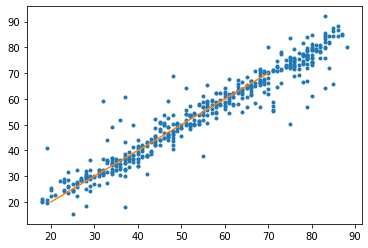

In [52]:
y_hat = model.predict(X_train_reshaped)
plt.plot(y_train, y_hat, linestyle="", marker=".")
plt.plot([20, 70], [20, 70])

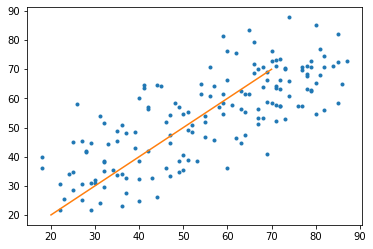

In [63]:
y_hat = model.predict(X_test_reshaped)
plt.plot(y_test, y_hat, linestyle="", marker=".")
plt.plot([20, 70], [20, 70])
plt.xlabel("X axis label")
plt.ylabel("Y axis label")

In [54]:
r2_score(y_test, y_hat)

0.5648199811503022